# Color classify

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # print('bin_spatial size:',len(features))
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector 
    # print('color_hist size:',len(hist_features))
    return hist_features


# Read in car and non-car images

#for filename in glob.iglob('./non-vehicles/**/*.png', recursive=True):
#    pass #print(filename)

notcars = glob.glob('./non-vehicles/**/*.png', recursive=True)
print('notcars:',len(notcars))

cars = glob.glob('./vehicles/**/*.png', recursive=True)
print('cars:',len(cars))


notcars: 8968
cars: 8792


# HOG classify

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        # print('get_hog_features size:',len(features))
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def images_from_file(file, cspace):
    # Iterate through the list of images

    # Read in each one by one
    image = mpimg.imread(file)
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)

    return feature_image



def extract_features(img, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, hist_bins=32):    
    # Apply bin_spatial() to get spatial color features
    spatial_size=(32, 32)
    feature_image = img

    spatial_features = bin_spatial(feature_image, size=spatial_size)
    hist_range=(0, 256)

    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_feat = get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True)
            hog_features.append(hog_feat)
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        hog_features = np.ravel(hog_features)
        
    feature_vec = np.concatenate((spatial_features, hist_features,hog_features))
    return feature_vec
    
def extract_features_from_paths(img_file_paths, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, hist_bins=32):
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in img_file_paths:
        feature_image = images_from_file(file, cspace)
        feature_vec = extract_features(feature_image, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel, hist_bins=hist_bins)
            
        # Append the new feature vector to the features list
        features.append(feature_vec)
    # Return list of feature vectors
    return features


### Training the classifier
In this step we will use train the SVM classifier.
The training data is a combination of spatial pixel features, a histogram of the distibution of the pixel intensity and a histogram of oriented gradients.

An important step is to scale the training data in order to normalize the input to the classifier.
We will return a reference to the scaler in order to reuse it for the detection of vehicles in new images.



In [8]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


def train_and_evaluate(cars, notcars, colorspace, orient, pix_per_cell, cell_per_block, hog_channel, C, hist_bins):

    t=time.time()
    car_features = extract_features_from_paths(cars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hist_bins=hist_bins)
    notcar_features = extract_features_from_paths(notcars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hist_bins=hist_bins)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Create an array stack of feature vectors
    # print('len(car_features)',len(car_features))
    # print('car_features[0].shape',car_features[0].shape)
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    print('X.shape',X.shape)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    #print('min X', np.min(X), 'max X', np.max(X))
    #print('mean X', np.mean(X), 'std X', np.std(X))

    # Split up data into randomized training and test sets
    rand_state = 42 #np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    # svc = SVC(C=C)
    # svc = DecisionTreeClassifier()
    svc = LinearSVC(C=C)
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    score = round(svc.score(X_train, y_train), 4)
    print('Train Accuracy of SVC = ', score)
    score = round(svc.score(X_test, y_test), 4)
    print('Test Accuracy of SVC = ', score)
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts:      ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return score, svc, X_scaler

Now that we have create some helper functions to train the classifier, we will limit the training dataset to 4000 randomly selected cars and 4000 randomly selected non cars images.

In [5]:
sample_size = 4000
selected_samples = np.random.choice(min(len(cars),len(notcars)),sample_size)

cars_sample = [cars[i] for i in selected_samples]
notcars_sample = [notcars[i] for i in selected_samples]
print('sample_size: ', len(cars_sample) + len(notcars_sample) )

### The following part of will perform a grid search on the features 
# calculation of the hyper parameters.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orients = [9]
pix_per_cells = [4,16]
cell_per_blocks = [2]
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
C_list = [1]
hist_bins_list = [16,20,]

param_gen=[(orient,pix_per_cell, cell_per_block, C, hist_bins) for orient in orients for pix_per_cell in pix_per_cells
             for cell_per_block in cell_per_blocks for C in C_list for hist_bins in hist_bins_list]

res = dict()
res['score'] = list()
res['params'] = list()
res['model'] = list() 
res['X_scaler'] = list()

# Grid search for best hyperparameters
for (orient,pix_per_cell, cell_per_block, C, hist_bins) in param_gen:
    try:
        print('orient:', orient, ' pix_per_cell:',pix_per_cell, ' cell_per_block:', cell_per_block,
              'C:', C, ' hist_bins:', hist_bins)
        score, svc, X_scaler = train_and_evaluate(cars_sample, notcars_sample, colorspace, orient, pix_per_cell,
                                   cell_per_block, hog_channel, C, hist_bins)
        res['score'].append(score)
        res['params'].append((orient,pix_per_cell, cell_per_block,C, hist_bins,))
        res['model'].append(svc)
        res['X_scaler'].append(X_scaler)
        
    #except Exception as ex:
    #    print('Exception: ', str(ex))
    finally:
        print('End of trial\n\n')
    
print('End computation')

sample_size:  4000 len(cars_sample):  4000
orient: 9  pix_per_cell: 4  cell_per_block: 2 C: 1  hist_bins: 16
95.82 Seconds to extract HOG features...
X.shape (8000, 27420)
Using: 9 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 27420
4.49 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9888
My SVC predicts:       [ 1.  1.  1.  1.  0.  1.  1.  1.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  0.  1.  1.  1.  0.  1.]
0.00181 Seconds to predict 10 labels with SVC
End of trial


orient: 9  pix_per_cell: 4  cell_per_block: 2 C: 1  hist_bins: 20
55.44 Seconds to extract HOG features...
X.shape (8000, 27432)
Using: 9 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 27432
4.75 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9888
My SVC predicts:       [ 1.  1.  1.  1.  0.  1.  1.  1.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  0.  1.  1.  1.  0.  1.]
0.00179 Seconds to p

In [7]:
scores = np.array(res['score'])
print(len(res['score']))
best_score_idx = np.argmax(res['score'])
print(np.max(scores, axis=0))
print('Best score is:', scores[best_score_idx], ' for parameters (orient,pix_per_cell, cell_per_block, C, hist_bins,) :',
     res['params'][best_score_idx])

#Best score is: 0.875  for paramters (orient,pix_per_cell, cell_per_block, C, hist_bins,) : (9, 4, 2, 1, 16)
print('Saving best performing model on validation data set.')
import pickle

pickle.dump(res['model'][best_score_idx], open('saved_svm_model.p', 'wb'))
pickle.dump(res['params'][best_score_idx], open('features_calc_params.p', 'wb'))
pickle.dump(res['X_scaler'][best_score_idx], open('features_scale.p', 'wb'))


4
0.99
Best score is: 0.99  for parameters (orient,pix_per_cell, cell_per_block, C, hist_bins,) : (9, 16, 2, 1, 16)
Saving best performing model on validation data set.


# Evaluate the performance of the classifier

### Simple evaluation

We will first perform a simple evaluation of the classifier on 10 examples

In [29]:
### Reload parameters saved from the disk.
colorspace = 'YCrCb'
orient,pix_per_cell, cell_per_block, C, hist_bins  = pickle.load(open('features_calc_params.p', 'rb'))
X_scaler  = pickle.load(open('features_scale.p', 'rb'))
svc = pickle.load(open('saved_svm_model.p', 'rb'))

sample_size = 5
selected_samples = np.random.choice(min(len(cars),len(notcars)),sample_size)

cars_sample = [cars[i] for i in selected_samples]
notcars_sample = [notcars[i] for i in selected_samples]
print('example_samples: ', len(example_samples) )

# Concatenate the list of 5 cars with the list of 5 non-cars
example_samples = cars_sample + notcars_sample

some_cars = extract_features_from_paths(example_samples, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hist_bins=hist_bins)
print(len(some_cars))

some_cars = np.vstack((some_cars)).astype(np.float64)

scaled_some_cars = X_scaler.transform(some_cars)

y_pred = svc.predict(scaled_some_cars)
print(y_pred)

example_samples:  10
10
[ 1.  1.  1.  1.  1.  0.  0.  0.  0.  0.]


### Confusion Matrix

Calculate Confusion Matrix on 10000 randomly selected examples

In [43]:
sample_size = 5000
selected_samples = np.random.choice(min(len(cars),len(notcars)),sample_size)

cars_sample = [cars[i] for i in selected_samples]
notcars_sample = [notcars[i] for i in selected_samples]

# Concatenate the list of 5000 cars with the list of 5000 non-cars
example_samples = cars_sample + notcars_sample

# Generating labels
y_test = np.zeros(sample_size*2)
y_test[0:y_test.shape[0]//2] = 1 # First halfs are cars and second half are non-cars

print('example_samples: ', len(example_samples) )


example_samples:  10000


In [52]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)


    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j]*100)/100,
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# This function plots the confusion matrix
# The original version of this implementation can be found on
# this page http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
 
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j]<1:
            plt.text(j, i, '{:.2}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


In [54]:
# Evaluate function on 10000 examples
some_cars = extract_features_from_paths(example_samples, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hist_bins=hist_bins)

some_cars = np.vstack((some_cars)).astype(np.float64)

scaled_some_cars = X_scaler.transform(some_cars)

y_pred = svc.predict(scaled_some_cars)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)



The number of false positives is fairly low. However a concerning aspect is that the number of false negatives is greater than 1%. This would not be suitable in a production car.  

Normalized confusion matrix
[[ 0.99  0.01]
 [ 0.02  0.98]]


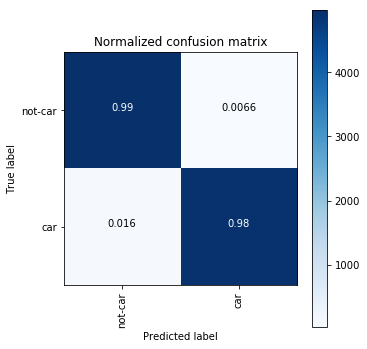

In [56]:
# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['not-car','car'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Hog Sub-sampling Window Search
This is a more efficient method than a sliding window technique.

This method allows us to execute the HOG algorithm features just once per frame.

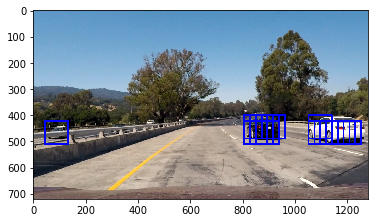

In [70]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

spatial_size=(32, 32)

img = mpimg.imread('test_images/test1.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).ravel()
            # print('hog_features size', len(hog_features))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (32,32))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size).ravel()
            hist_features = color_hist(subimg, nbins=hist_bins).ravel()
            # Scale features and make a prediction
            feature_vec = np.concatenate((spatial_features, hist_features,hog_features)).ravel()
            test_features = X_scaler.transform(feature_vec.reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart),))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, bbox_list
    
ystart = 400
ystop = 656
scale = 1.4
    
out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)
plt.show()

## Heatmap

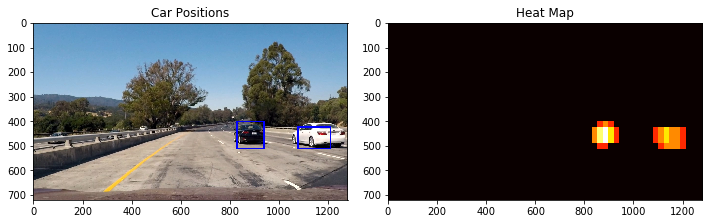

2 cars found


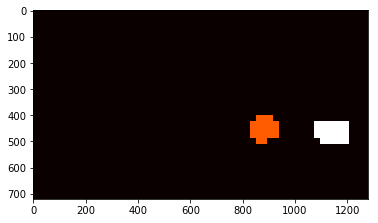

In [281]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
box_list = bbox_list 

# Read in image similar to one shown above 
image = img
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def get_labeled_bboxes(labels):
    # Iterate through all detected cars
    bbox_list = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        bbox_list.append(bbox)
    return bbox_list

def draw_labeled_bboxes(img, bbox_list):
    for bbox in bbox_list:
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img
    
# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
#draw_img = draw_labeled_bboxes(np.copy(image), labels)

bbox_list = get_labeled_bboxes(labels)
draw_img = draw_labeled_bboxes(np.copy(image), bbox_list)

fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='hot')
plt.show()




## Video processing callback. 
This function chooses which lane finding algorithm to use as a function of the estimated quality of the algorithm.
The function choose between lane_sliding_window and poly_envelope_lane_search.


### Avoiding false positives,

In order to avoid false positives we will use a combination of labeled box thresholding, spatial filtering and temporal filtering.
Spatial filtering : I used gaussian filtering to group dis-connected boxes around a car together 
Temporal filtering : I used a FIR filter on successive frames
Labeled box thresholding: Only the strongest cell candidates should be retained.


In [365]:
# In order to stabilize 
class Filter:
    """
    
    This class is a static class. 
    Just one instance of the parameters is needed.
    """
    value = dict()
    
    def __init__(self):
        self.value = dict()
        self.z = None
        self.coeffs = np.array([0.2, 0.3, 0.5])
        self.index = 0
        self.bbox_list_z = list()
    
    def apply_coef_heat(self, heatblur):
        if self.z is None:
             self.z = np.zeros(shape=(heatblur.shape[0], heatblur.shape[1],
                                               self.coeffs.shape[0]))
        self.z[:,:, self.index] = heatblur
        heat = np.zeros_like(heatblur)
        
        for i, roll in zip(range(self.coeffs.shape[0]), range(self.index, self.index+self.coeffs.shape[0], 1)):
            roll_i = roll if roll < self.coeffs.shape[0] else roll - self.coeffs.shape[0]
            #print('(i, roll, roll_i):',(i, roll, roll_i))
            heat  = heat + self.z[:,:, roll_i] * self.coeffs[i]
        
        self.index = self.index + 1 if self.index < self.coeffs.shape[0]-1 else 0
        self.z[:, :, self.index] = heat
        
        return heat

            
            
    def get_z(self):
        return self.z


In [411]:
# Define callback for processing image

spatial_size=(32, 32)
ystart = 400
ystop = 656
scale = .85

def process_image(image):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    out_img, bbox_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 4)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255).astype(np.float32)
    heatblur = cv2.GaussianBlur(heatmap,(0,0),12)
    filteredheat = filt.apply_coef_heat(heatblur)
    
    # Find final boxes from heatmap using label function
    labels = label(filteredheat)
    bbox_list = get_labeled_bboxes(labels)
    #filt.apply_coef_bbox(bbox_list)
    draw_img = draw_labeled_bboxes(np.copy(image), bbox_list)
    
    return draw_img
    

# Testing pipeline on a few images




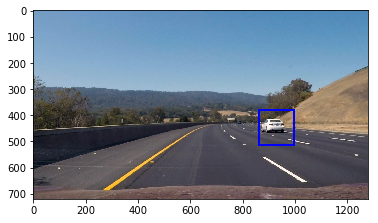

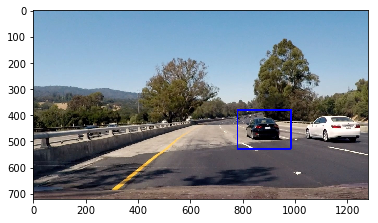

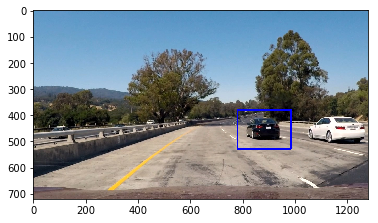

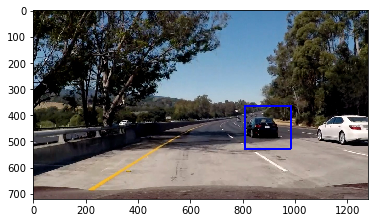

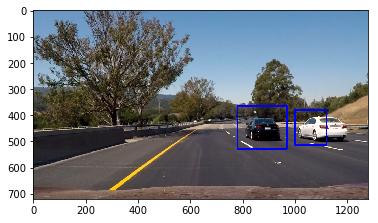

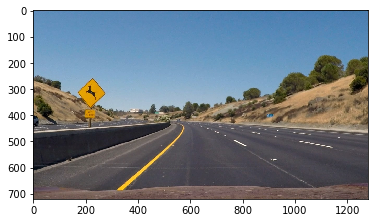

In [412]:

imgs_paths = glob.glob('./test_images/*.jpg', recursive=True)
for im_path in imgs_paths:
    filt = Filter()
    image = mpimg.imread(im_path)
    im_out = process_image(image)
    plt.imshow(im_out)
    plt.show()

None


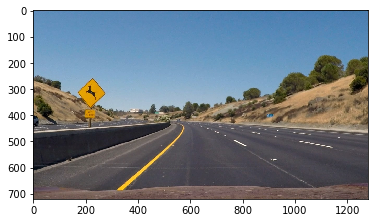

[MoviePy] >>>> Building video ./output_images/project_video.mp4
[MoviePy] Writing video ./output_images/project_video.mp4


  2%|▏         | 25/1261 [00:14<11:44,  1.75it/s]

In [ ]:

filt = Filter()
print(filt.get_z())

from moviepy.editor import VideoFileClip
clip = VideoFileClip("project_video.mp4")
plt.imshow(image)
plt.show()

#clip = VideoFileClip("./test_video.mp4")
video_output = './output_images/project_video.mp4'

processed_clip = clip.fl_image(process_image)

%time processed_clip.write_videofile(video_output, audio=False)
